<a href="https://www.kaggle.com/code/qlasty/ai-cookbook-capstone?scriptVersionId=233809532" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 📖 Introduction

This is a notebook that summarizes some of the knowledge gained through the **5-day Gen AI Intensive Course with Google** in a form of the **Gen AI Intensive Course Capstone 2025Q1**.  

It implements the intelligent chef assistant bot, whose main capabilities are:
* selection of proper cookbook based on users suggestion
* suggestion of a recipe eg. based on available ingredients
* dummy ordering of ingredients

The **gen AI capabilities** used in the notebook are:  
✅ Embeddings  
✅ Few shot prompting  
✅ Structured output/JSON mode/controlled generation  
✅ Retrieval augmented generation (RAG)  
✅ Vector search/vector store/vector database   
✅ Agents with LangGraph

# ⚒ Installation and setup

In [1]:
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai

!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 12.1 MB/s eta 0:00:00


In [2]:
!pip install -qU "google-genai==1.7.0" "chromadb==0.6.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.2 MB/s eta 0:

Verify installed genai version

In [3]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

Setup the API key and env variable.

In [4]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

# This is crucial, necessary for LangGraph invoke
os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY

# 📚 Cookbook data corpus preparation

From the attached dataset **Cookbooks** select some books and get the first N characters, based on which the titles will be retrieved later.

In [5]:
import os
import re
import json
import typing_extensions as typing
from google.api_core import retry

CLIP = 250
NUM_BOOKS = 5
BOOKS_STEP = 12

book_headers = []
book_file_names = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in sorted(filenames)[::BOOKS_STEP][:NUM_BOOKS]:
        with open(os.path.join(dirname, filename), "r") as fh:
            book = fh.read()

        book_headers.append(book[:CLIP])
        book_file_names.append(filename)
        print(filename)

amem.txt
chin.txt
epia.txt
grea.txt
linc.txt


## 📝 Titles retrieval
Define json schema for a function output, to help structure the few_shot_prompt and LLM call output format.
Capabilities:
* **few shot prompting**
* **structured output/JSON mode/controlled generation**

In [6]:

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

class BookInfo(typing.TypedDict):
    title: str
    authors: list[str]

In [7]:
few_shot_prompt = """Parse the begining of any book to retrieve title and authors. Note there can be many new-line characters (\n) inside the text.

EXAMPLE:
\n \n \n \n The American Woman's Home: or, Principles of Domestic Science; being a Guide to the Formation and Maintenance of Economical, Healthful, Beautiful, and Christian Homes.  Beecher, Catharine Esther  Stowe, Harriet Beecher  Home economics.  Introduction. The Christian Family. A Christian House. A Healthful Home.
JSON Response:
```
{
"title": "The American Woman's Home: or, Principles of Domestic Science; being a Guide to the Formation and Maintenance of Economical, Healthful, Beautiful, and Christian Homes.",
"authors": ["Catharine Beecher", "Stowe Esther", "Beecher Harriet"]
}
```

EXAMPLE:
\n\n Directions for Cookery, in its Various Branches.\n Leslie, Eliza \nCookery, American.\n
JSON Response:
```
{
"title": "Directions for Cookery, in its Various Branches.",
"authors": ["Eliza Leslie"]
}
```

EXAMPLE:
\n\n \n\n \nA bookplate illustration of a illuminated reading lap and an open book.  \nThis book belongs to Beatrice V. Grant.\n\n
JSON Response:
```
{
"title": "A bookplate illustration of a illuminated reading lap and an open book.",
"authors": ["Beatrice V. Grant"]
}
```
"""



titles_retrieved = [] 

@retry.Retry(predicate=is_retriable, timeout=3.0)
def extract_header(customer_order):
    print("=========================")
    print("Original book header:\n")
    print(customer_order)
    
    response = client.models.generate_content(
        model='gemini-1.5-flash',
        config=types.GenerateContentConfig(
            temperature=0.1,
            response_mime_type="application/json",
            max_output_tokens=CLIP,
            response_schema=BookInfo,
        ),
        contents=[few_shot_prompt, customer_order])

    print("=========================")
    print("Retrieved title and authors:")
    print(response.text)
    print("")
    print("=========================\n")
    return response
    
for customer_order in book_headers:
    
    try:        
        response = extract_header(customer_order)
        book_info = json.loads(response.text)
        titles_retrieved.append(book_info.get("title"))
    except json.JSONDecodeError as e:
        print("error")
        titles_retrieved.append("")


Original book header:

 
 

 
  

 
 
 


 The American Matron: Or, Practical and Scientific Cookery. 


 By a Housekeeper. 


 Boston: J. Munroe &amp; Co., 1851 

 [Page images for  The American Matron  were produced before MSU began the "Feeding America" digitization pro
Retrieved title and authors:
{"title": "The American Matron: Or, Practical and Scientific Cookery.", "authors": ["a Housekeeper"]}


Original book header:

 
 
  
 
 Chinese-Japanese Cook Book 
 Bosse, Sara 
 Watanna, Onoto 
 Cookery, Chinese. Cookery, Japanese. Cookery, American. 
 Part 1 Chinese Recipes. Rules for Cooking. Soups. Gravy. Fish. Poultry and Game. Meats. Chop Sueys. Chow Mains. Fried Rice
Retrieved title and authors:
{"title": "Chinese-Japanese Cook Book", "authors": ["Sara Bosse", "Onoto Watanna"]}


Original book header:

 
 
 
  The Epicurean...  Ranhofer, Charles.  Cookery, American. Cookery, French. Menus.  Complete title: The Epicurean. A complete treatise of Analytical and Practical Studies on t

# 🧠 RAG utilities
## Basic text chunking

In [8]:
# function generated with gemini-2.5
def dummy_chunk_text(text, chunk_size=500, overlap=30):
    """
    Creates dummy chunks of text with a specified chunk size and overlap,
    prioritizing not splitting words in the middle.

    Args:
        text (str): The input text.
        chunk_size (int): The target size for each chunk (in characters).
        overlap (int): The number of characters to overlap between chunks.

    Returns:
        list: A list of text chunks.
    """
    if chunk_size <= 0:
        raise ValueError("chunk_size must be positive")
    if overlap < 0:
        raise ValueError("overlap cannot be negative")

    chunks = []
    start = 0
    text_length = len(text)

    while start < text_length:
        end = min(start + chunk_size, text_length)

        if end < text_length and text[end].isalnum() and (end > 0 and text[end-1].isalnum()):
            last_space = text.rfind(' ', start, end)
            if last_space > start:
                end = last_space

        chunk = text[start:end]

        if chunk.strip():
            chunks.append(chunk.strip()) # Strip leading/trailing whitespace from the chunk itself
        if end == text_length:
            break

        next_start = end - overlap
        start = max(next_start, start + 1)

    return chunks

## Embedding function for RAG system
This will make embeddings of text chunks (obtained with dummy_chunk_text) that will be stored in a vector database. Later a user query will allow to retrieve (hopefully) the most relevant chunks.

In [9]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry

from google.genai import types


class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model="models/text-embedding-004",
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]

Helper method to navigate through book titles.

In [10]:
from IPython.display import Markdown

def truncate(t: str, limit: int = 50) -> str:
  """Truncate labels to fit on the chart."""
  if len(t) > limit:
    return t[:limit-3] + '...'
  else:
    return t

# 🔩 Tools for LLM to use
Several tools are specified here:
* find_cuisine - Find appropriate cookbook based on how the provided query matches the title of a book - based on semantic similarity (capability: **Embeddings**)
* summarize_cookbook - Summarize cookbook (perform indexing with vector database) - (capability: **RAG**)
* retrieve_recipe - Retrieves relevant information about user requested recipe - (capability: **RAG**)
* order_ingredients - Orders desired ingredients in the nearby store - (capability: just **function calling** like other methods)

In [11]:
import numpy as np
import chromadb
import pandas as pd

STEP = 100
DB_NAME = "googlecardb_local"
embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)


def find_cuisine(cuisine_query: str) -> str:
    """Find appropriate cookbook based on how the provided query matches the title of a book
    
    
    """
    query = titles_retrieved + [cuisine_query]
    
    truncated_texts = [truncate(t) for t in query]
    
    response = client.models.embed_content(
        model='models/text-embedding-004',
        contents=query,
        config=types.EmbedContentConfig(task_type='semantic_similarity'))
    
    df = pd.DataFrame([e.values for e in response.embeddings], index=truncated_texts)
    # Perform the similarity calculation

    sim = df @ df.T
    filename = book_file_names[sim[cuisine_query].iloc[:-1].argmax()]

    return filename


def summarize_cookbook(filename: str) -> None:
    """Summarize cookbook (perform indexing with vector database"""

    with open(os.path.join('/kaggle/input/cookbooks', filename), "r") as fh:
        long_text = fh.read()
    
    long_text = long_text.replace("\n", "")
    
    chunks = dummy_chunk_text(long_text)
    
    embed_fn = GeminiEmbeddingFunction()
    embed_fn.document_mode = True

    # Chunk the book as at most 100 vectors can be added in single batch to the database
    for x in range(0, len(chunks), STEP):
        small_chunk = chunks[x: x+STEP-1]
        db.add(documents=small_chunk, ids=[str(i + x) for i in range(len(small_chunk))])

def retrieve_recipe(recipe_query: str) -> str:
    """Retrieves relevant information about user requested recipe.

    Parameters:
    recipe_query: str
        user query about recipe he wants to get

    Returns:
        str: chunks of relevant recipes found in the cookbook.
    """
    # Switch to query mode when generating embeddings.
    embed_fn.document_mode = False
    
    result = db.query(query_texts=[recipe_query], n_results=5)
    [all_passages] = result["documents"]

    prompt = ""
    # Add the retrieved documents to the prompt.
    for passage in all_passages:
        passage_oneline = passage.replace("\n", " ")
        prompt += f"PASSAGE: {passage_oneline}\n"

    return prompt



def order_ingredients(ingredients: list[str]) -> bool:
    """Orders desired ingredients in the nearby store.
    
    Parameters:
    ingredients: tuple[str]
        iterable of ingredients to order

    Returns:
        bool: whether the order was succesfull
    
    """
    total_succes = 0
    for item in ingredients:
        if np.random.random()<0.9:
            print(f"{item} ordered!")
            total_succes += 1
        else:
            print(f"{item} is missing in the shop!")

    return total_succes == len(ingredients)


Gather tools and prepare chat bot instructions.

In [12]:
bot_tools = [order_ingredients, retrieve_recipe, find_cuisine, summarize_cookbook]

In [13]:
chat_instructions = f"""You are a helpful bot - the cook assistant. 
You should guide the user through following steps:
- ask about the type of cuisine he wants - use tool find_cuisine for you to find the appropriate cookbook file_name
- now as you have access to a selected cookbook with many of interesting recipes - you can use a tool summarize_cookbook which needs the file_name found
- you should propose a recipe based on ingredients indicated by your chef. Your output should contain four parts:
* Name of dish and extremely brief summary
* Detailed preparation guide (try to describe each step based also on your knowledge - put this information that is not present in the book in the braces)
* Ingredients chef already has
* Ingredients missing and what is missing)

You have acess also to tools order_ingredients to order desired ingredients for a selected recipe AND a atool retrieve_recipe - in order to get recipe chunks from the cookbook based on which 
you summarize it according to a provided guide. Note that you have to always rely on the recipe text chunks obtained with the retrieve_recipe. You are not allowed to propose a recipe that does not come
from a retrieve_recipe text chunks.

"""

# 💬 Configure the chat and start conversation

In [14]:
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=chat_instructions,
        tools=bot_tools
    )
)

In [15]:
resp = chat.send_message("I wish some Chinese food today!")
print(f"\n{resp.text}")


The cookbook has been summarized. Now, tell me what ingredients you already have, so I can suggest a recipe you can make with them.



In [16]:
resp = chat.send_message("I have a salmon and plenty of rice.")
print(f"\n{resp.text}")



I found a recipe that seems promising. It's called 'Fried Rice with Chicken and Mushrooms'. Although it does not contain salmon, we can adjust it to include salmon instead of chicken.

*Name of dish and extremely brief summary:* Fried Rice with Salmon and Mushrooms - A savory dish where rice is stir-fried with salmon, mushrooms, celery, and other vegetables.

*Detailed preparation guide:*

1.  Boil one pound of rice for twenty minutes (make sure it is not too sticky, rinse it well).
2.  Prepare the following: Take one pound of cooked salmon (you can bake, steam, or pan-fry the salmon). Cut the salmon into small pieces.
3.  Put a tablespoonful of pork fat (or any cooking oil) in the pan, and when it is very hot turn in the salmon and fry for a few minutes.
4.  Then cut up two stalks of celery, one onion, and six water chestnuts, and add with the syou (soy sauce), cayenne, and salt.
5.  Fry all for ten minutes, then place the rice in a platter and pour the above over it.
6.  Cover tight

In [17]:
query = "Excellent! Please order the missing ingredients."
resp = chat.send_message(query)
print(f"\n{resp.text}")

Pork fat ordered!
Mushrooms ordered!
Celery ordered!
Onion ordered!
Water chestnuts ordered!
Syou ordered!
Cayenne pepper ordered!
Salt is missing in the shop!
Parsley is missing in the shop!

I am sorry, I was unable to order these ingredients. Please try again.



In [18]:
query = "Thanks, have a nice day!"
resp = chat.send_message(query)
print(f"\n{resp.text}")


You're welcome! If you need anything else in the future, feel free to ask. Enjoy your meal!



## Preview the details of conversation

In [19]:
import textwrap


def print_chat_turns(chat):
    """Prints out each turn in the chat history, including function calls and responses."""
    for event in chat.get_history():
        print(f"{event.role.capitalize()}:")

        for part in event.parts:
            if txt := part.text:
                print(f'  "{txt}"')
            elif fn := part.function_call:
                args = ", ".join(f"{key}={val}" for key, val in fn.args.items())
                print(f"  Function call: {fn.name}({args})")
            elif resp := part.function_response:
                print("  Function response:")
                print(textwrap.indent(str(resp.response['result']), "    "))

        print()


print_chat_turns(chat)

User:
  "I wish some Chinese food today!"

Model:
  Function call: find_cuisine(cuisine_query=Chinese)

User:
  Function response:
    chin.txt

Model:
  "OK. I have found a Chinese cookbook. Before I propose a specific recipe, let me summarize what this cookbook offers. This will give you an overview of the recipes available.
"
  Function call: summarize_cookbook(filename=chin.txt)

User:
  Function response:
    None

Model:
  "The cookbook has been summarized. Now, tell me what ingredients you already have, so I can suggest a recipe you can make with them.
"

User:
  "I have a salmon and plenty of rice."

Model:
  "OK. I will find a recipe that includes salmon and rice.
"
  Function call: retrieve_recipe(recipe_query=salmon and rice)

User:
  Function response:
    PASSAGE: repare the following: Take one pound of cooked  chicken  and cut it in small pieces. Put a tablespoonful of  pork fat  in the pan, and when it is very hot turn in the  chicken  and fry for a few minutes. Then cut

# 🥷 Agentic approach 

## State class
Prepare class to store conversation history and success state of the conversation, along with ingredients lits.

In [20]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class RecipeState(TypedDict):
    """State representing the cook chef's conversation."""

    # chats history
    messages: Annotated[list, add_messages]

    # list of ingredients eventually to buy
    order: list[str]

    # Flag indicating that the chef is satisfied
    finished: bool

## Extended and updated instruction for the Agent

In [21]:
CHEF_BOT_SYSINT = (
    "system",
    chat_instructions + " If order of products was not succesfull, allow chef to continue without the product if he wishes to or try to order them again - ask chef for that.\n "
    "Say goodbye and wish buon appetite when finished. "
    "After some software update, all functions you know now have the suffix '_tool' added, so it is a 'find_cuisine_tool' rather than just 'find_cuisine' and 'retrieve_recipe_tool' rather than 'retrieve_recipe' and so on. "
    "Additionally you have confirm_satisfaction_tool to finish conversation when chef is satified and add_to_order_tool to place desired ingredients to order in the nearbye store.",
)
WELCOME_MSG = "Welcome to the ChefBot helper. Type `q` to quit. How may I serve you today?"

## Tools for the Agent and nodes for the graph

In [22]:
from langchain_core.messages.tool import ToolMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages.ai import AIMessage

from collections.abc import Iterable

@tool
def find_cuisine_tool(cuisine_query: str) -> str:
    """Finds the appropriate cookbook for users request."""
    return find_cuisine(cuisine_query)

@tool
def summarize_cookbook_tool(filename: str):
    """Summarizes the selected cookbook."""
    return summarize_cookbook(filename)

@tool
def retrieve_recipe_tool(recipe_query: str) -> str:
    """Retrieves recipes as RAG utility."""
    return retrieve_recipe(recipe_query)

@tool
def add_to_order_tool(ingredients: Iterable[str]) -> str:
    """Adds the specified ingredient for order.

    Returns:
      The updated order in progress.    """


@tool
def order_ingredients_tool() -> str:
    """Asks the chef if the order is correct.

    Returns:
      The user's free-text response.
    """


@tool
def confirm_satisfaction_tool():
    """Confirms chef's satisfaction with the help from chatbot, after recipe is presented and ingredients discussed.
    """



def actions_node(state: RecipeState) -> RecipeState:
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", [])
    outbound_msgs = []
    chat_finished = False

    for tool_call in tool_msg.tool_calls:
        if tool_call["name"] == "add_to_order_tool":
            order.extend(f'{tool_call["args"]["ingredients"]}')
            response = "\n".join(order)
        
        elif tool_call["name"] == "confirm_order_tool":
            print("Your order:")
            if not order:
                print("  (no items)")

            for ingredient in order:
                print(f"  {ingredient}")

            response = input("Is this correct? ")
        
        elif tool_call["name"] == "order_ingredients_tool":
            response = "Ingredients ordered!"
            
        elif tool_call["name"] == "confirm_satisfaction_tool":
            response = "I am glad I could help!"
            chat_finished = True
            
        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    
    return {"messages": outbound_msgs, "order": order, "finished": chat_finished}


def human_node(state: RecipeState) -> RecipeState:
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


# Comment this out if you wish interactive chat (based on 'input') instead of pre arranged user messages (for notebook demonstration purposes)
input_strings = ["I want chinese food today.", "All I have is some rice, I will take your suggested recipe.", "Please, order missing ingredients.", "I am happy with your help, thank you."]
input_iterator = iter(input_strings)

def human_node(state: RecipeState) -> RecipeState:
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    try:
        user_input = next(input_iterator)  # Get the next input from the iterator
        print(f"User: {user_input}") # Print user input from array
    except StopIteration:
        state["finished"] = True
        return state  # Exit if the iterator is exhausted

    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}



## Conditional edges

In [23]:
from typing import Literal

def maybe_route_to_tools(state: RecipeState) -> str:
    """Route between chat and tool nodes if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "context_tools"
        else:
            return "action_tools"
    
    else:
        return "human"


def maybe_exit_human_node(state: RecipeState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

## Full graph building for the Agent

In [24]:

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

def chatbot_with_tools(state: RecipeState) -> RecipeState:
    defaults = {"order": [], "finished": False}

    if state['messages']:
        new_output = llm_with_tools.invoke([CHEF_BOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    return defaults | state | {'messages': [new_output]}


# --------- tools
auto_tools = [find_cuisine_tool, summarize_cookbook_tool, retrieve_recipe_tool]
actions_tools = [add_to_order_tool, order_ingredients_tool, confirm_satisfaction_tool]

tool_node = ToolNode(auto_tools)

llm_with_tools = llm.bind_tools(auto_tools + actions_tools)

# --------- graph
graph_builder = StateGraph(RecipeState)

# nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("context_tools", tool_node)
graph_builder.add_node("action_tools", actions_node)

# edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("context_tools", "chatbot")
graph_builder.add_edge("action_tools", "chatbot")
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_graph = graph_builder.compile()

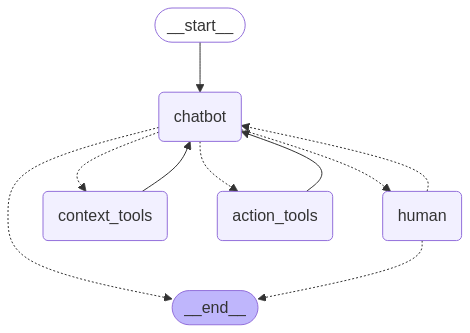

In [25]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

## 💬 Test the Agentic Chatbot 
In this notebook a pre arranged user messages are run in a chat with the bot.

In [26]:
config = {"recursion_limit": 100}
state = chat_graph.invoke({"messages": []}, config)

Model: Welcome to the ChefBot helper. Type `q` to quit. How may I serve you today?
User: I want chinese food today.
Model: Our cookbook on Chinese cuisine includes recipes for Kung Pao Chicken,  Mapo Tofu, and Egg Fried Rice among others.  I need to retrieve a specific recipe to help you. What ingredients do you have available at the moment?
User: All I have is some rice, I will take your suggested recipe.
Model: OK. Let's prepare Egg Fried Rice then.

**Name of dish:** Egg Fried Rice. A quick and easy Chinese classic.

**Detailed preparation guide:**

1. Prepare the rice: Ideally, use day-old rice as it's firmer and less sticky. If you only have freshly cooked rice, spread it on a plate to cool and dry slightly. (This helps prevent the rice from becoming mushy).
2. Prepare the other ingredients: Finely chop the green onions.  Whisk the eggs lightly with a pinch of salt. (Consider adding other vegetables like diced carrots, peas, or chopped bell peppers for extra flavor and nutrients).

In [27]:
from pprint import pprint
pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

{'finished': True,
 'messages': [AIMessage(content='Welcome to the ChefBot helper. Type `q` to quit. How may I serve you today?', additional_kwargs={}, response_metadata={}, id='d927d4bc-9f9a-4172-a918-769a475d5851'),
              HumanMessage(content='I want chinese food today.', additional_kwargs={}, response_metadata={}, id='41a02dd5-0965-41b6-a3d7-949e4031f00d'),
              AIMessage(content='', additional_kwargs={'function_call': {'name': 'find_cuisine_tool', 'arguments': '{"cuisine_query": "chinese"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run-c1f33c8a-3ccd-4be8-a8a8-5fa83b6c6c99-0', tool_calls=[{'name': 'find_cuisine_tool', 'args': {'cuisine_query': 'chinese'}, 'id': '703f9db1-02f7-4a1f-996c-53f40e9b70bf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 544, 'output_tokens': 9, 'total_tokens': 553, 'input_token_details': {'cache_read': 0}}